In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, LabelEncoder

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

## Описание данных

В данной работе будет использоваться набор данных  [Medical Cost Personal](https://www.kaggle.com/mirichoi0218/insurance), содержащий в себе информацию о страховых выплатах медицинскому персоналу

Описание признаков:
* age - возраст бенефициара (лица, получающего страховые выплаты);
* sex - пол бенефициара;
* bmi - [индексы массы тела](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%BC%D0%B0%D1%81%D1%81%D1%8B_%D1%82%D0%B5%D0%BB%D0%B0);
* children - количество детей бенефициара, на которых распространяется страхование / количество иждевенцов бенефициара;
* smoker - является ли бенефициар курильщиком;
* region - жилой район бенефициара в США: северо-восток, юго-восток, юго-запад, северо-запад;
* charges - индивидуальные медицинские расходы, выставленные на счет медицинского страхования.

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Смотри какого типа каждый из признаков, есть ли пропущенные значения

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Думаю, что стоит построить ящик с усами для категориальных переменных. Эта диаграмма  позволит понять, есть ли разница в целевом показателе в данных категориях

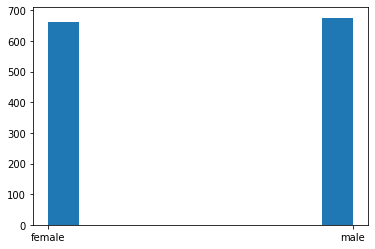

In [5]:
plt.hist(data['sex'])
plt.show()

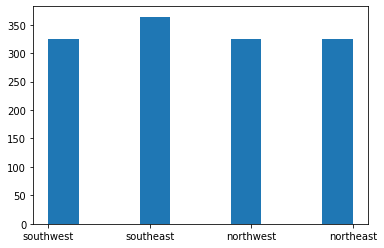

In [6]:
plt.hist(data['region'])
plt.show()

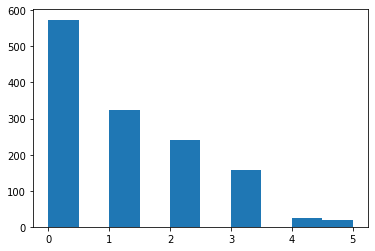

In [7]:
plt.hist(data['children'])
plt.show()

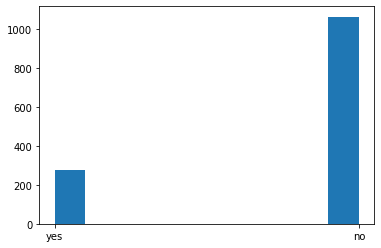

In [8]:
plt.hist(data['smoker'])
plt.show()

Выполняем попарное построение диаграммы рассеяния, чтобы визуально оценить взаимоотношения между признаками

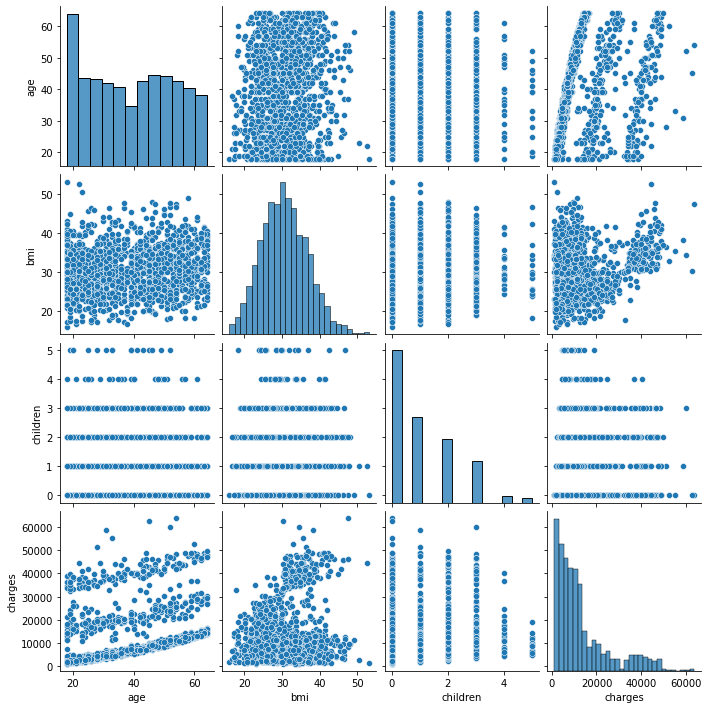

In [9]:
sns.pairplot(data, kind = "scatter")

Похоже, что между данными нет линейной зависмости. Убедимся в этом, построив матрицу корелляции

<AxesSubplot:>

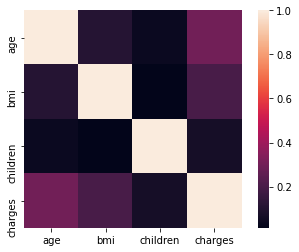

In [10]:
sns.heatmap(data.corr(), square=True)

In [11]:
prepared_data = data.copy().drop(columns=['charges'])
target = data['charges']

Выполним визуализацию данных, чтобы посмотреть на зависимость между признаками и целевым показателем. Однако, в нашем случае пространство переменных является многомерном. Чтобы провести визуализацию нужно придти к пространству меньшей размерности. Для этого можно воспользоваться методом главных компонент (МГК)

Прежде чем использовать МГК, нужно выполнить преобразование данных

В  первую очередь заменим категориальные переменные численными

In [12]:
label_encoder = LabelEncoder()
categorical_columns = prepared_data.select_dtypes(include='object').columns
for column in categorical_columns:
    prepared_data[column] = label_encoder.fit_transform(prepared_data[column])

In [13]:
prepared_data.head()

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1


Затем, необходимо выполнить нормализацию данных, чтобы МГК смог найти информативные переменные

In [14]:
pca_data = Normalizer().fit_transform(prepared_data)

Применияем МГК. Приводим данные в одномерное пространство

In [15]:
pca = PCA(n_components=1)
pca_data = pca.fit_transform(pca_data)

Формируем набор данных для визуализации

In [16]:
visualize_data = np.dstack((pca_data.flatten(), target.to_numpy())).reshape(1338, 2)
visualize_data = pd.DataFrame(data=visualize_data, columns=['x', 'y'])
visualize_data.head()

,x,y
0,0.276701,16884.92400
1,0.379477,1725.55230
2,0.172127,4449.46200
3,-0.091668,21984.47061
4,0.039233,3866.85520


<AxesSubplot:xlabel='x', ylabel='y'>

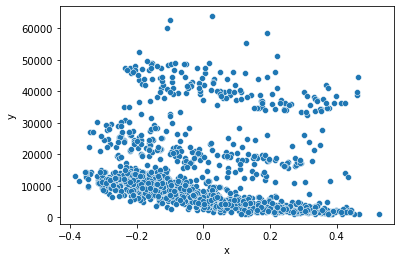

In [17]:
sns.scatterplot(data=visualize_data, x='x', y='y')

## Выбор метода машинного обучения для решения поставленной задачи

Принимая во внимание нелинейную зависимость данных первым на ум приходит Random Forest. Однако, нужно учесть один существенный недостаток данного метода - случайный лес не умеет экстраполировать. Предсказания целевой переменной, которые будут получены от данного алгоритма - это средние значения целевого признака из примеров обучающей выборки. Однако, это не означает, что этот алгоритм не стоит использовать

В данном случае, наверное, будет неуместо использовать такие модели как LASSO, Ridge и Elastik-Net из-за отсутствия мультиколлинеарности.

In [18]:
prepared_data.head()

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1


In [19]:
prepared_target = np.log(target)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    prepared_data,
    prepared_target,
    test_size=0.33,
    random_state=42
)

In [21]:
def grid_search_cv(model, params, X, y):
    trained_model = GridSearchCV(model, params, cv=5, n_jobs=-1)
    trained_model.fit(X, y)
    return trained_model

In [22]:
params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'C': [0.1, 0.5, 1, 5, 10]
}

svr_cv = grid_search_cv(SVR(), params, X_train, y_train)

In [23]:
y_pred = svr_cv.best_estimator_.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

0.4473042937482653

In [24]:
params = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 2.5, 5],
    'normalize': [True, False]
}

ridge_cv = grid_search_cv(Ridge(), params, X_train, y_train)

In [25]:
y_pred = ridge_cv.best_estimator_.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

0.4336045558143928

In [26]:
params = {
    'max_depth': [None, 6, 8, 10],
    'min_samples_split': [3, 5, 10, 15],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfr_cv = grid_search_cv(RandomForestRegressor(), params, X_train, y_train)

In [27]:
y_pred = rfr_cv.best_estimator_.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

0.37281601790551366

In [28]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
y_pred = linear_regression.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

0.43359847384115674

In [30]:
ridge_cv.best_params_

{'alpha': 0.001, 'normalize': True}

In [31]:
estimators = [
    ('ridge', Ridge(**ridge_cv.best_params_)),
    ('random_forest_regressor', RandomForestRegressor(**rfr_cv.best_params_)),
    ('svr', SVR(**svr_cv.best_params_))
]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(random_state=42)
)

stacking_regressor.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('ridge',
                               Ridge(alpha=0.001, copy_X=True,
                                     fit_intercept=True, max_iter=None,
                                     normalize=True, random_state=None,
                                     solver='auto', tol=0.001)),
                              ('random_forest_regressor',
                               RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=6,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decre...
                                    

In [32]:
y_pred = stacking_regressor.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

0.3960754569793887

In [33]:
y_pred = stacking_regressor.estimators_[1].predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

0.37392120892603037